In [54]:
import pandas as pd
import numpy as np
import re
import io
import tensorflow.keras as keras
from IPython.display import clear_output

In [55]:
import matplotlib.pyplot as plt

In [56]:
stop_words = []
with open("stopwords.txt", "r", encoding="UTF-8") as file:
    stop_words = [line.strip() for line in file]

In [38]:
df = pd.read_csv('./dataframe.csv')

In [39]:
df.columns=['text','Resultado']

In [59]:
texto = df.loc[0].text

In [77]:
terms_filter(terms_cleaner(texto.split(" ")))

['APELAÇÃO',
 'CÍVEL',
 'INDENIZAÇÃO',
 'DANOSMORAIS',
 'MATERIAIS',
 'COBRANÇA',
 'INDEVIDA',
 'DÉBITO',
 'QUITADO',
 'FALHA',
 'PRESTAÇÃO',
 'SERVIÇOS',
 'PROVA',
 '373DO',
 'DANOS',
 'MORAIS',
 'INCORRÊNCIA',
 'Incumbe',
 'autor',
 'daprova',
 'relação',
 'fatos',
 'constitutivos',
 'direito',
 'termos',
 'artigo373',
 'inciso',
 'Código',
 'Processo',
 'Civil',
 'Embora',
 'desagradável',
 'parteapelante',
 'cobrança',
 'equivocada',
 'conta',
 'telefonia',
 'móvel',
 'houvepagamento',
 'consumidor',
 'negativação',
 'junto',
 'aoSPC/SERASA',
 'acarreta',
 'consequentemente',
 'indenizaçãocompensatória',
 'danos',
 'morais',
 'havendo',
 'comprovação',
 'pagamentodo',
 'boleto',
 'falar',
 'restituição',
 'encargoAPELAÇÃO',
 'CÍVEL',
 '10000171052079/002',
 'COMARCA',
 'DEFORA',
 'APELANTE',
 'GERALDO',
 'HENRIQUE',
 'REMIDIO',
 'APELADO',
 'BANCO',
 'Acorda',
 'CÂMARA',
 'CÍVEL',
 'deste',
 'Tribunal',
 'Justiça',
 'Estado',
 'deMinas',
 'Gerais',
 'conformidade',
 'julgamentos',


In [76]:
def terms_cleaner(terms):
        for i in range(len(terms)):
            chars_to_delete = ('.', ',', "(", ")", "'", '"', "-", "*", ":")
            for char in chars_to_delete: 
                terms[i] = terms[i].replace(char, "")
            #terms[i] = re.sub('\d','',terms[i])
        return terms

def terms_filter(terms):
    # len(term) > 3
    return list(filter(lambda term: term not in stop_words and len(term) > 4, terms))

class TF_IDF_Model:
    def __init__(self, most_relevant_to_0, most_relevant_to_1, idf_0, idf_1):
        self.most_relevant_to_0 = most_relevant_to_0
        self.most_relevant_to_1 = most_relevant_to_1
        self.idf_0 = idf_0
        self.idf_1 = idf_1
        
    def calculate_point(self, document):
        terms = terms_filter(terms_cleaner(document.split(" ")))
        result = []

        count_terms = np.unique(terms, return_counts=True)
        count_terms = pd.Series(count_terms[1],index=count_terms[0], dtype=np.integer)

        for search_terms, idf in ((self.most_relevant_to_0, self.idf_0), (self.most_relevant_to_1, self.idf_1)):
            search_terms_frequence = count_terms.loc[pd.Index.intersection(search_terms,count_terms.index)].reindex(search_terms,fill_value=0)
            tf = np.log(1 + search_terms_frequence/len(terms))
            result.append((tf * idf).sum())
        return result
        
    def calculate_multiple_points(self, documents):
        return np.array([self.calculate_point(document) for document in documents])
    

class TF_IDF:
    def __init__(self, documents, results):
        terms = documents.str.split(" ").apply(terms_cleaner).apply(terms_filter)
              
        frequencies = terms.apply(lambda terms: np.transpose(np.unique(terms, return_counts=True))).apply(lambda terms: pd.Series(terms.T[1].astype(np.int32),index=terms.T[0])).T.fillna(0)
        frequencies.columns = pd.MultiIndex.from_arrays([results,frequencies.columns], names=["Results", "id"]).sort_values()
        
        tf = np.log(1 + frequencies/frequencies.sum(axis=0))
        self.idf = frequencies.sum(axis=1).rdiv(1)
        tf_idf = tf.mul(self.idf,axis=0)
        relevance = tf_idf.sum(level=0,axis=1)
        self.metric = relevance[0] - relevance[1]
        self.metric.sort_values(inplace=True)
    
    def build_model(self, border):
        most_relevant_to_0 = self.metric.index[-border:]
        most_relevant_to_1 = self.metric.index[:border]
        idf_0 = self.idf[most_relevant_to_0]
        idf_1 = self.idf[most_relevant_to_1]
        
        return TF_IDF_Model(most_relevant_to_0, most_relevant_to_1, idf_0, idf_1)

In [64]:
train_df = pd.concat([df[:df.shape[0]//4],df[df.shape[0]//2:3 * df.shape[0]//4]])
test_df = pd.concat([df[df.shape[0]//4:df.shape[0]//2],df[3 * df.shape[0]//4:]])

In [65]:
tf_idf = TF_IDF(train_df.text, train_df.Resultado)

In [66]:
def grafic_plot(texts, results, model, labels=['_nolegend_','_nolegend_'], axis=plt):    
    ponts0 = []
    ponts1 = []
    for text, result in zip(texts, results):
        x, y = model.calculate_point(text)
        if(result):
            ponts1.append((x, y))
        else:
            ponts0.append((x, y))
    ponts1 = np.array(ponts1).T
    ponts0 = np.array(ponts0).T
    
    axis.plot(*ponts0,'ro', label=labels[0])
    axis.plot(*ponts1,'bo', label=labels[1])

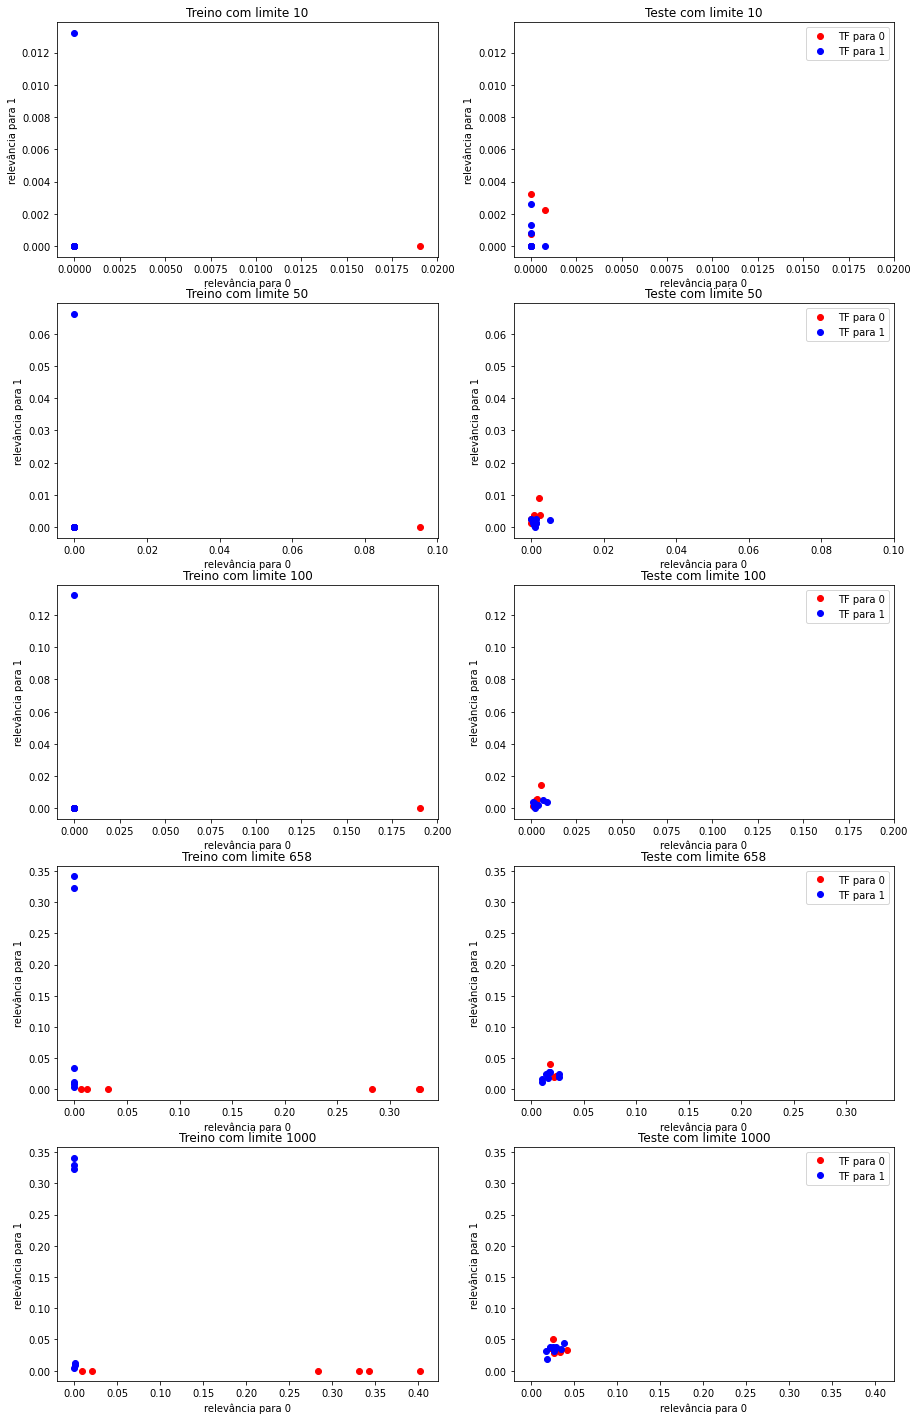

In [67]:
passos = [10, 50, 100, 658,1000]
fig, axes = plt.subplots(len(passos),2, figsize=(15,5 * len(passos)))
for passo, row_axes in zip(passos,axes):
    modelo = tf_idf.build_model(passo)
    
    grafic_plot(train_df.text, train_df.Resultado, modelo, axis=row_axes[0])
    grafic_plot(test_df.text, test_df.Resultado, modelo, labels=["TF para 0", "TF para 1"], axis=row_axes[1])
    row_axes[0].set_title(f"Treino com limite {passo}")
    row_axes[0].set_xlabel("relevância para 0")
    row_axes[0].set_ylabel("relevância para 1")
    row_axes[1].set_title(f"Teste com limite {passo}")
    row_axes[1].axis(row_axes[0].axis())
    row_axes[1].set_xlabel("relevância para 0")
    row_axes[1].set_ylabel("relevância para 1")
    row_axes[1].legend()

# Testes com regressão linear

In [68]:
def betas_calculate(tf_idf, results):
    return np.linalg.pinv(np.c_[np.ones(tf_idf.shape[0]).T,tf_idf]) @ results

In [69]:
def linear_rating(betas, inputs, expected):
    results = (np.c_[np.ones(inputs.shape[0]).T,inputs] @ betas) > .5
    return (results == expected).sum() / results.shape[0]

In [70]:
def bounds_test(begin, end, step):
    max_value = 0
    max_bound = 0    
    for i in range(begin, end, step):
        tf_idf_model = tf_idf.build_model(i)
        tf_idf_train = tf_idf_model.calculate_multiple_points(train_df.text)

        betas = betas_calculate(tf_idf_train, train_df.Resultado)
        rating = linear_rating(betas, tf_idf_train, train_df.Resultado)
        if(rating > max_value):
            max_bound = i
            max_value = rating
    return max_bound, max_value, tf_idf_model, betas

In [71]:
bounds_test(0,1000,100)

(700,
 0.8333333333333334,
 array([ 0.60361474, -1.9436331 ,  1.31982257]))

melhor = testar_limites(0, 1000, 100)[0]
melhor = testar_limites(melhor-100, melhor+100, 10)[0]
melhor = testar_limites(melhor-10, melhor+10, 1)

In [72]:
step = 10
x = []
y1 = []
y2 = []
for i in range(0,1000,step):
    print("="*(i//10)," "*(100 - i//10),f"\n{i}/1000",sep="")
    tf_idf_model = tf_idf.build_model(i)
    tf_idf_train = tf_idf_model.calculate_multiple_points(train_df.text)
    betas = betas_calculate(tf_idf_train, train_df.Resultado)
    x.append(i)
    y1.append(linear_rating(betas, tf_idf_train, train_df.Resultado))
    
    tf_idf_test = tf_idf_model.calculate_multiple_points(test_df.text)
    y2.append(linear_rating(betas, tf_idf_test, test_df.Resultado))
    clear_output()

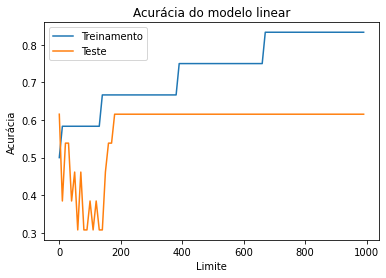

In [73]:
plt.title("Acurácia do modelo linear")
plt.xlabel("Limite")
plt.ylabel("Acurácia")
plt.plot(x, y1, label="Treinamento")
plt.plot(x, y2, label="Teste")
plt.legend()
plt.show()

# Testes com K-means

In [51]:
def model_k_means_train(tf_idf, results, k):
    def model(x0,x1):
        return results[((tf_idf.T - np.array([[x0],[x1]])) ** 2).sum(axis=0).argsort()[:k]].mean()
    return model

def test_model(k_means_model, tf_idf, results):
    hits = 0
    for (x0, x1), expected in zip(tf_idf, results):
        hits += (k_means_model(x0,x1) > .5) == expected
    return hits/test_df.Resultado.shape[0]

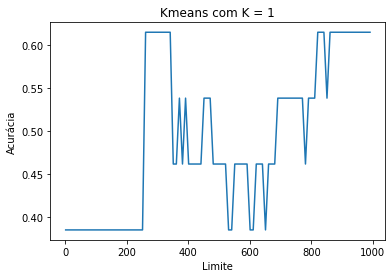

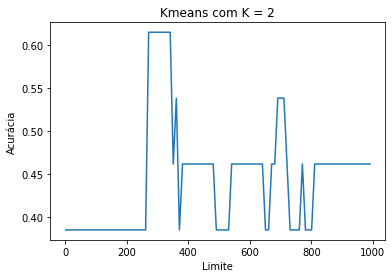

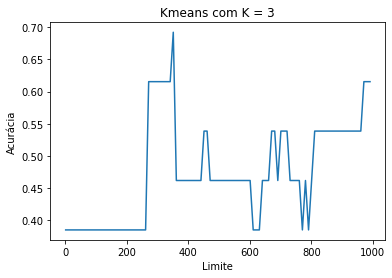

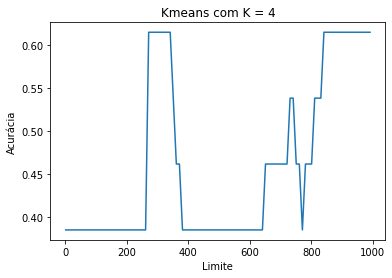

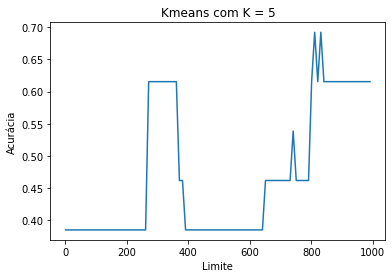

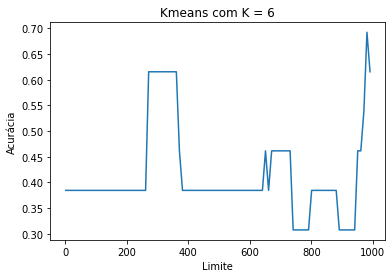

In [52]:
for k in range(1,7):
    x = []
    y = []
    for i in range(1, 1000,10):
        tf_idf_model = tf_idf.build_model(i)
        tf_idf_train = tf_idf_model.calculate_multiple_points(train_df.text)
        tf_idf_test = tf_idf_model.calculate_multiple_points(test_df.text)
        
        k_means_model = model_k_means_train(tf_idf_train, train_df.Resultado.values, k)
        x.append(i)
        y.append(test_model(k_means_model, tf_idf_test, test_df.Resultado.values))

    plt.title(f"Kmeans com K = {k}")
    plt.xlabel("Limite")
    plt.ylabel("Acurácia")
    plt.plot(x, y)
    plt.show()

In [31]:
tf_idf_model = tf_idf.build_model(10)

# Testes com SVM
https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/contrib/learn/SVM

In [ ]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation

In [ ]:
def use_svm(tf_idf_bound):
    tf_idf_model = tf_idf.build_model(tf_idf_bound)
    tf_idf_train = tf_idf_model.calculate_multiple_points(train_df.text)
    tf_idf_test = tf_idf_model.calculate_multiple_points(test_df.text)
    
    model = Sequential([
        Flatten(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(2, kernel_regularizer=l2(0.0001)),
        Activation('linear')
    ])


    model.compile(loss='hinge',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    history = model.fit(tf_idf_train, train_df.Resultado, epochs=10)
    train_accuracy = history.history['accuracy'][-1]
    
    _, test_accuracy = model.evaluate(tf_idf_test,test_df.Resultado)
    clear_output()
    return train_accuracy, test_accuracy

In [ ]:
dados = []
for i in range(1, 1000, 10):
    dados.append(use_svm(i))

In [ ]:
x = np.arange(1, 1000, 10)

In [ ]:
y1, y2 = np.array(dados).T

In [ ]:
plt.title("Acurácia do SVM")
plt.xlabel("Limite")
plt.ylabel("Acurácia")
plt.plot(x, y1, label="Treinamento")
plt.plot(x, y2, label="Teste")
plt.legend()
plt.show()